# Meddef Model for Defense of Medical Images Against Adversarial Attacks

In [ ]:
# Import necessary modules
import os
import logging
import torch
from torch import nn
import torchvision
from tabulate import tabulate
import sys
import json

import numpy as np
import pandas as pd

from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split, WeightedRandomSampler
from torchvision.datasets import ImageFolder
from torchvision import transforms, datasets
from torchvision.transforms import functional as f
import cv2
from typing import Dict, Optional, Tuple, Union, cast
from collections import Counter
from collections.abc import Sized
import nibabel as nib

# Set the logging level
logging.basicConfig(level=logging.INFO)


In [254]:
#Get System Info
print("Torch version: ", torch.__version__)
print("Torchvision version: ", torchvision.__version__)
print("CUDA available: ", torch.cuda.is_available())
print('System Version:', sys.version)
print('System Version Information:', sys.version_info)
print('System Path:', sys.path)
print('System Executable:', sys.executable)
print('System Platform:', sys.platform)
print('System Maxsize:', sys.maxsize)
print('System Implementation:', sys.implementation)


Torch version:  1.9.0+cu102
Torchvision version:  0.10.0+cu111
CUDA available:  True
System Version: 3.8.8 (default, Apr 13 2021, 19:58:26) 
[GCC 7.3.0]
System Version Information: sys.version_info(major=3, minor=8, micro=8, releaselevel='final', serial=0)
System Path: ['D:\\Apps\\PyCharm 2024.1.1\\plugins\\python\\helpers-pro\\jupyter_debug', 'D:\\Apps\\PyCharm 2024.1.1\\plugins\\python\\helpers\\pydev', '/data2/enoch', '/usr/local/anaconda3/lib/python38.zip', '/usr/local/anaconda3/lib/python3.8', '/usr/local/anaconda3/lib/python3.8/lib-dynload', '', '/data2/enoch/.local/lib/python3.8/site-packages', '/usr/local/anaconda3/lib/python3.8/site-packages', '/usr/local/anaconda3/lib/python3.8/site-packages/locket-0.2.1-py3.8.egg', '/usr/local/anaconda3/lib/python3.8/site-packages/IPython/extensions', '/data2/enoch/.ipython']
System Executable: /usr/local/anaconda3/bin/python
System Platform: linux
System Maxsize: 9223372036854775807
System Implementation: namespace(_multiarch='x86_64-linux-

# Utility Functions


In [ ]:
## Timer

In [ ]:
def setup_logger(log_file):
    directory = os.path.dirname(log_file)
    if not os.path.exists(directory):
        os.makedirs(directory)

    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s',
        handlers=[
            logging.FileHandler(log_file),
            logging.StreamHandler()
        ]
    )
    logging.info("Logger initialized.")

# Load datasets
### Dataset Class




In [255]:
# Global Directory
data_dir = '/data2/enoch/ekd_coding_env/meddef_winlab/dataset'

In [256]:
# Confirm that the directory exists
# Check if the directory exists
if os.path.exists(data_dir):
    print(f"Directory exists: {data_dir}")
    # List the files in the directory
    files = os.listdir(data_dir)
    print("Files or folders in directory:")
    for file in files:
        print(file)
else:
    print(f"Directory does not exist: {data_dir}")

Directory exists: /data2/enoch/ekd_coding_env/meddef_winlab/dataset
Files or folders in directory:
miccai_brats2020
rotc
chest_xray
tbcr
scisic
mnist
ccts


In [280]:
# Initialize the DatasetLoader class
datasets_dict = DatasetLoader.get_all_datasets(data_dir)
# Print the keys of the datasets_dict to verify initialization
print(datasets_dict.keys())

INFO:root:DatasetLoader initialized for ccts.
INFO:root:DatasetLoader initialized for tbcr.
INFO:root:DatasetLoader initialized for scisic.
INFO:root:DatasetLoader initialized for rotc.


dict_keys(['ccts', 'tbcr', 'scisic', 'rotc'])


In [281]:
# # Load the miccai_brats2020 dataset
# miccai_brats2020_dataset = datasets_dict['miccai_brats2020']
# train_loader, val_loader, test_loader = miccai_brats2020_dataset.load()
# 
# # Function to display attributes of the dataset


In [282]:

# Display the structure of the dataset
# print(f"Training set size: {len(train_loader)}")
# print(f"Validation set size: {len(val_loader)}")
# print(f"Test set size: {len(test_loader)}")

In [283]:
# import numpy as np
# from PIL import Image
# 
# def display_dataset_shapes(dataset, dataset_name):
#     print(f"\n{dataset_name} - Number of samples: {len(dataset)}")
#     for i in range(min(3, len(dataset))):  # Display only the first 3 samples for brevity
#         image, label = dataset[i]
#         
#         # Convert numpy.memmap to numpy.ndarray if necessary
#         if isinstance(image, np.memmap):
#             image = np.array(image)
#         
#         # Convert numpy.ndarray to PIL Image
#         if isinstance(image, np.ndarray):
#             image = Image.fromarray(image)
#         
#         print(f"Sample {i+1}:")
#         print(f"  Image shape (CHW): {image.size}")
#         print(f"  Image dimensions: {image.ndim}")
#         print(f"  Label: {label}")
# 
# # Display the size and shape of images in the train, validation, and test datasets
# display_dataset_shapes(train_loader.dataset, "Training Dataset")
# display_dataset_shapes(val_loader.dataset, "Validation Dataset")
# display_dataset_shapes(test_loader.dataset, "Test Dataset")

In [284]:
# Understanding the dataset

def display_image(image, title, ax, dataset_name=None):
    if image is None:
        raise ValueError("Input image is None.")
    if not isinstance(image, (np.ndarray, torch.Tensor, np.memmap)):
        raise TypeError("Unsupported image type. Must be np.ndarray, torch.Tensor, or np.memmap.")

    print(f"Initial image type: {type(image)}, shape: {image.shape}")

    if isinstance(image, np.memmap):
        image = np.array(image)
        print(f"Converted from memmap to ndarray, shape: {image.shape}")

    if isinstance(image, torch.Tensor):
        image = image.detach().cpu().numpy()
        print(f"Converted from tensor to ndarray, shape: {image.shape}")

    if image.ndim not in [2, 3, 4]:
        raise ValueError(f"Unsupported image dimensions: {image.ndim}. Expected 2D, 3D, or 4D image.")

    if image.ndim == 4:
        image = image[:, :, :, image.shape[3] // 2]
        print(f"Selected middle slice for 4D image, new shape: {image.shape}")

    if image.ndim == 3:
        if image.shape[0] in [1, 3]:
            image = np.transpose(image, (1, 2, 0))
            print(f"Transposed 3D image to (H, W, C), new shape: {image.shape}")

    if image.ndim == 3 and image.shape[-1] == 1:
        image = np.squeeze(image, axis=-1)
        print(f"Squeezed single-channel image, new shape: {image.shape}")

    if image.dtype == np.float32 or image.max() <= 1.0:
        image = np.clip(image * 255, 0, 255).astype(np.uint8)
        print(f"Scaled image to 0-255 range, dtype: {image.dtype}")

    if image.ndim == 2:
        image = np.stack([image] * 3, axis=-1)
        print(f"Converted 2D grayscale image to 3D RGB, new shape: {image.shape}")

    try:
        pil_image = Image.fromarray(image.astype(np.uint8))
        print(f"Converted image to PIL format, mode: {pil_image.mode}")
    except Exception as e:
        raise ValueError(f"Error converting image to PIL format: {e}")

    ax.imshow(pil_image, cmap='gray' if pil_image.mode == 'L' else None)
    ax.set_title(title)
    ax.axis('off')

def print_dataset_heads(datasets_dict, num_samples=5):
    for dataset_name, dataset_loader in datasets_dict.items():
        try:
            logging.info(f"Displaying head for dataset: {dataset_name}")
            train_loader, val_loader, test_loader = dataset_loader.load()
            
            # Display samples from the training set
            print(f"\nDataset: {dataset_name} - Training Set")
            fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
            for i, (image, label) in enumerate(train_loader):
                if i >= num_samples:
                    break
                display_image(image, f"Train Sample {i+1} - Label: {label}", axes[i], dataset_name=dataset_name)
            plt.show()

        except Exception as e:
            logging.error(f"Error displaying head for dataset {dataset_name}: {e}")

INFO:root:Displaying head for dataset: ccts
INFO:root:Loading dataset: ccts.



Dataset: ccts - Training Set
Initial image type: <class 'torch.Tensor'>, shape: torch.Size([3, 224, 224])
Converted from tensor to ndarray, shape: (3, 224, 224)
Transposed 3D image to (H, W, C), new shape: (224, 224, 3)
Scaled image to 0-255 range, dtype: uint8
Converted image to PIL format, mode: RGB
Initial image type: <class 'torch.Tensor'>, shape: torch.Size([3, 224, 224])
Converted from tensor to ndarray, shape: (3, 224, 224)
Transposed 3D image to (H, W, C), new shape: (224, 224, 3)
Scaled image to 0-255 range, dtype: uint8
Converted image to PIL format, mode: RGB
Initial image type: <class 'torch.Tensor'>, shape: torch.Size([3, 224, 224])
Converted from tensor to ndarray, shape: (3, 224, 224)
Transposed 3D image to (H, W, C), new shape: (224, 224, 3)
Scaled image to 0-255 range, dtype: uint8
Converted image to PIL format, mode: RGB
Initial image type: <class 'torch.Tensor'>, shape: torch.Size([3, 224, 224])
Converted from tensor to ndarray, shape: (3, 224, 224)
Transposed 3D im

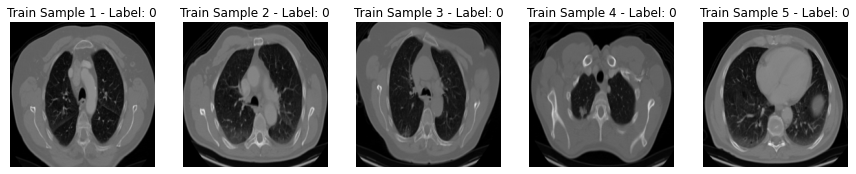

INFO:root:Displaying head for dataset: tbcr
INFO:root:Loading dataset: tbcr.



Dataset: tbcr - Training Set
Initial image type: <class 'torch.Tensor'>, shape: torch.Size([3, 224, 224])
Converted from tensor to ndarray, shape: (3, 224, 224)
Transposed 3D image to (H, W, C), new shape: (224, 224, 3)
Scaled image to 0-255 range, dtype: uint8
Converted image to PIL format, mode: RGB
Initial image type: <class 'torch.Tensor'>, shape: torch.Size([3, 224, 224])
Converted from tensor to ndarray, shape: (3, 224, 224)
Transposed 3D image to (H, W, C), new shape: (224, 224, 3)
Scaled image to 0-255 range, dtype: uint8
Converted image to PIL format, mode: RGB
Initial image type: <class 'torch.Tensor'>, shape: torch.Size([3, 224, 224])
Converted from tensor to ndarray, shape: (3, 224, 224)
Transposed 3D image to (H, W, C), new shape: (224, 224, 3)
Scaled image to 0-255 range, dtype: uint8
Converted image to PIL format, mode: RGB
Initial image type: <class 'torch.Tensor'>, shape: torch.Size([3, 224, 224])
Converted from tensor to ndarray, shape: (3, 224, 224)
Transposed 3D im

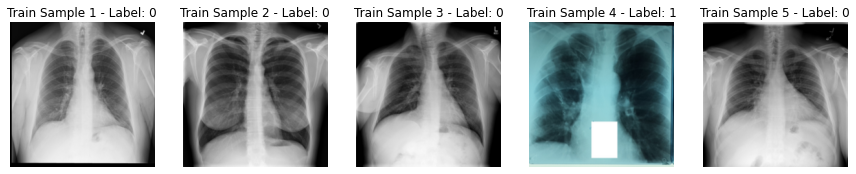

INFO:root:Displaying head for dataset: scisic
INFO:root:Loading dataset: scisic.



Dataset: scisic - Training Set
Initial image type: <class 'torch.Tensor'>, shape: torch.Size([3, 224, 224])
Converted from tensor to ndarray, shape: (3, 224, 224)
Transposed 3D image to (H, W, C), new shape: (224, 224, 3)
Scaled image to 0-255 range, dtype: uint8
Converted image to PIL format, mode: RGB
Initial image type: <class 'torch.Tensor'>, shape: torch.Size([3, 224, 224])
Converted from tensor to ndarray, shape: (3, 224, 224)
Transposed 3D image to (H, W, C), new shape: (224, 224, 3)
Scaled image to 0-255 range, dtype: uint8
Converted image to PIL format, mode: RGB
Initial image type: <class 'torch.Tensor'>, shape: torch.Size([3, 224, 224])
Converted from tensor to ndarray, shape: (3, 224, 224)
Transposed 3D image to (H, W, C), new shape: (224, 224, 3)
Scaled image to 0-255 range, dtype: uint8
Converted image to PIL format, mode: RGB
Initial image type: <class 'torch.Tensor'>, shape: torch.Size([3, 224, 224])
Converted from tensor to ndarray, shape: (3, 224, 224)
Transposed 3D 

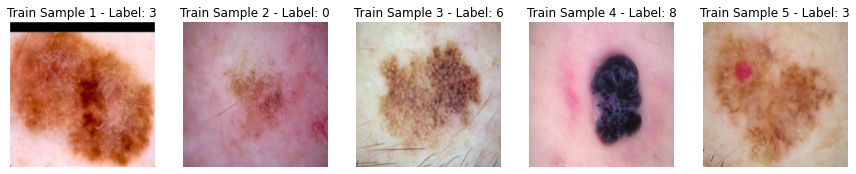

INFO:root:Displaying head for dataset: rotc
INFO:root:Loading dataset: rotc.



Dataset: rotc - Training Set
Initial image type: <class 'torch.Tensor'>, shape: torch.Size([3, 224, 224])
Converted from tensor to ndarray, shape: (3, 224, 224)
Transposed 3D image to (H, W, C), new shape: (224, 224, 3)
Scaled image to 0-255 range, dtype: uint8
Converted image to PIL format, mode: RGB
Initial image type: <class 'torch.Tensor'>, shape: torch.Size([3, 224, 224])
Converted from tensor to ndarray, shape: (3, 224, 224)
Transposed 3D image to (H, W, C), new shape: (224, 224, 3)
Scaled image to 0-255 range, dtype: uint8
Converted image to PIL format, mode: RGB
Initial image type: <class 'torch.Tensor'>, shape: torch.Size([3, 224, 224])
Converted from tensor to ndarray, shape: (3, 224, 224)
Transposed 3D image to (H, W, C), new shape: (224, 224, 3)
Scaled image to 0-255 range, dtype: uint8
Converted image to PIL format, mode: RGB
Initial image type: <class 'torch.Tensor'>, shape: torch.Size([3, 224, 224])
Converted from tensor to ndarray, shape: (3, 224, 224)
Transposed 3D im

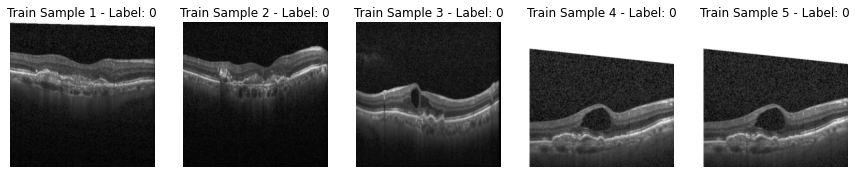

In [285]:
# Check the head of each dataset
# Call the function to print the head of each dataset
print_dataset_heads(datasets_dict)

In [286]:


def print_dataset_shapes(datasets_dict):
    for dataset_name, dataset_loader in datasets_dict.items():
        try:
            logging.info(f"Getting shapes for dataset: {dataset_name}")
            train_loader, val_loader, test_loader = dataset_loader.load()
            
            # Get the shape of the first batch of each dataset
            train_shape = next(iter(train_loader))[0].shape
            val_shape = next(iter(val_loader))[0].shape if val_loader else None
            test_shape = next(iter(test_loader))[0].shape if test_loader else None
            
            # Print the shapes
            print(f"\nDataset: {dataset_name}")
            print(f"Training Set Shape: {train_shape}")
            print(f"Validation Set Shape: {val_shape}")
            print(f"Test Set Shape: {test_shape}")

        except Exception as e:
            logging.error(f"Error getting shapes for dataset {dataset_name}: {e}")

# Call the function to print the shapes of each dataset
print_dataset_shapes(datasets_dict)

INFO:root:Getting shapes for dataset: ccts
INFO:root:Loading dataset: ccts.
INFO:root:Getting shapes for dataset: tbcr
INFO:root:Loading dataset: tbcr.
INFO:root:Getting shapes for dataset: scisic
INFO:root:Loading dataset: scisic.
INFO:root:Getting shapes for dataset: rotc
INFO:root:Loading dataset: rotc.



Dataset: ccts
Training Set Shape: torch.Size([3, 224, 224])
Validation Set Shape: torch.Size([3, 224, 224])
Test Set Shape: torch.Size([3, 224, 224])

Dataset: tbcr
Training Set Shape: torch.Size([3, 224, 224])
Validation Set Shape: torch.Size([3, 224, 224])
Test Set Shape: torch.Size([3, 224, 224])

Dataset: scisic
Training Set Shape: torch.Size([3, 224, 224])
Validation Set Shape: torch.Size([3, 224, 224])
Test Set Shape: torch.Size([3, 224, 224])

Dataset: rotc
Training Set Shape: torch.Size([3, 224, 224])
Validation Set Shape: torch.Size([3, 224, 224])
Test Set Shape: torch.Size([3, 224, 224])


# Preprocessing

### Preprocess Methods

In [287]:
def de_texturize_transform():
    return transforms.Lambda(lambda img: img.filter(ImageFilter.GaussianBlur(radius=2)))

def de_colorize_transform():
    return transforms.Grayscale(num_output_channels=1)

def edge_enhance_transform():
    return transforms.Lambda(lambda img: img.filter(ImageFilter.EDGE_ENHANCE))

def salient_edge_map_transform():
    def edge_detection(tensor_img):
        if tensor_img.shape[0] == 3:
            img = tensor_img.numpy().transpose(1, 2, 0).astype(np.uint8)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        else:
            img = tensor_img.numpy().squeeze(0).astype(np.uint8)
        edges = cv2.Canny(img, 100, 200)
        edges = np.stack([edges, edges, edges], axis=0)
        return torch.tensor(edges, dtype=torch.float32) / 255.0

    return transforms.Lambda(edge_detection)

def brightness_adjust_transform(factor):
    return transforms.Lambda(lambda img: f.adjust_brightness(img, factor))

def add_grayscale_transform(transform_list, input_channels, train_dataset=None):
    if input_channels == 3 and train_dataset is not None and hasattr(train_dataset, 'classes') and train_dataset.classes[0] == '0':
        transform_list.insert(1, transforms.Grayscale(num_output_channels=3))

def add_normalization_transform(transform_list, input_channels):
    if input_channels == 1:
        transform_list.append(transforms.Normalize((0.1307,), (0.3081,)))
    else:
        transform_list.append(transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)))



In [288]:
def augment_minority_class(img):
    img = transforms.RandomRotation(10)(img)
    return img

def handle_class_imbalance(img, dataset):
    if hasattr(dataset, 'targets'):
        targets = dataset.targets
    elif hasattr(dataset, 'labels'):
        targets = dataset.labels
    else:
        raise ValueError("Dataset must have 'targets' or 'labels' attribute.")

    class_counts = np.bincount(targets)
    majority_class = np.argmax(class_counts)
    minority_class = 1 - majority_class

    if targets[img] == minority_class:
        img = Image.fromarray(img.numpy().astype(np.uint8))
        img = augment_minority_class(img)
        img = transforms.ToTensor()(img)

    return img



In [289]:
def add_weighted_sampler(dataset, sampler):
    dataset.targets = dataset.targets if hasattr(dataset, 'targets') else dataset.labels
    dataset.targets_sampler = sampler
    return dataset

def get_weighted_sampler(dataset):
    targets = dataset.targets if hasattr(dataset, 'targets') else dataset.labels
    class_sample_count = np.array([len(np.where(targets == t)[0]) for t in np.unique(targets)])
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in targets])
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True)
    return sampler

def verify_labels(dataset):
    label_counts = Counter()
    for _, label in dataset:
        label_counts[label] += 1
    majority_label = label_counts.most_common(1)[0][0]
    corrected_labels = [majority_label if label != majority_label else label for _, label in dataset]
    dataset.labels = corrected_labels
    return dataset

In [291]:
# Get Transforms

def get_transforms(input_channels, dataset_name, train_dataset=None):
    pil_transform_list = [
        transforms.Resize((256, 256)),
        transforms.CenterCrop((224, 224)),
        # transforms.RandomHorizontalFlip(),

        # transforms.RandomRotation(10),
        # transforms.RandomResizedCrop(224),

        # self.de_texturize_transform(),
        # self.de_colorize_transform(),
        # self.edge_enhance_transform(),
    ]
    if dataset_name == 'ccts':
        pil_transform_list.extend([
          
          
        ])
    elif dataset_name == 'tbcr':
        pil_transform_list.extend([
            transforms.Grayscale(num_output_channels=1),
            transforms.Lambda(lambda img: handle_class_imbalance(img, train_dataset)),
        ])
    elif dataset_name == 'scisic':
        pil_transform_list.extend([
            # Add specific transforms for 'scisic'
        ])
    elif dataset_name == 'rotc':
        pil_transform_list.extend([
            # Add specific transforms for 'rotc'
        ])

    to_tensor_transform = transforms.ToTensor()
    tensor_transform_list = [
        # Add tensor transforms if needed
    ]
    all_transforms = pil_transform_list + [to_tensor_transform] + tensor_transform_list

    if input_channels is not None:
        add_normalization_transform(all_transforms, input_channels)
    return transforms.Compose(all_transforms)

In [292]:
def extract_classes(dataset):
    classes, _ = print_class_counts(dataset)
    if classes is None:
        raise ValueError("Could not determine the number of classes.")
    return classes

In [293]:
def print_class_counts(dataset):
    logging.info("Calculating class counts")
    if isinstance(dataset, torch.utils.data.Subset):
        original_dataset = dataset.dataset
    else:
        original_dataset = dataset

    if hasattr(original_dataset, 'classes'):
        classes = original_dataset.classes
    else:
        logging.warning("The dataset does not have a 'classes' attribute.")
        return None, None

    indices = dataset.indices if isinstance(dataset, torch.utils.data.Subset) else range(len(original_dataset))
    class_counts = [0] * len(classes)
    for idx in indices:
        _, label = original_dataset[idx]
        class_counts[label] += 1

    logging.info(f"Classes: {classes}")
    logging.info(f"Class counts: {class_counts}")

    return classes, class_counts


In [ ]:

def calculate_basic_statistics(dataset):
    data_list = []
    for data, _ in dataset:
        data_list.append(data.numpy())
    data_array = np.array(data_list)
    mean = np.mean(data_array, axis=0)
    median = np.median(data_array, axis=0)
    std_dev = np.std(data_array, axis=0)
    global_mean = np.mean(mean)
    global_median = np.mean(median)
    global_std_dev = np.mean(std_dev)
    logging.info(f"Global Mean: {global_mean}, Global Median: {global_median}, Global Standard Deviation: {global_std_dev}")

calculate_basic_statistics(datasets_dict['ccts'].load()[0])
calculate_basic_statistics(datasets_dict['tbcr'].load()[0])
calculate_basic_statistics(datasets_dict['scisic'].load()[0])
calculate_basic_statistics(datasets_dict['rotc'].load()[0])



INFO:root:Loading dataset: ccts.
INFO:root:Global Mean: 0.32299283146858215, Global Median: 0.2861211895942688, Global Standard Deviation: 0.2242301106452942
INFO:root:Loading dataset: tbcr.
INFO:root:Global Mean: 0.5073811411857605, Global Median: 0.512475311756134, Global Standard Deviation: 0.1894039660692215
INFO:root:Loading dataset: scisic.
INFO:root:Global Mean: 0.6397674083709717, Global Median: 0.6508362889289856, Global Standard Deviation: 0.13731986284255981
INFO:root:Loading dataset: rotc.


In [272]:
# def visualize_samples(model_name, dataset, dataset_name, task_name, num_samples=5):
#     output_dir = os.path.join('out', task_name, dataset_name, 'pre_visualization')
#     os.makedirs(output_dir, exist_ok=True)
# 
#     sample_images = []
#     sample_labels = []
#     for i in range(num_samples):
#         img, label = dataset[i]
#         if isinstance(img, torch.Tensor):
#             img = img.permute(1, 2, 0).numpy()
#         if img.shape[2] == 1:
#             img = img.squeeze()
#             img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
#         sample_images.append(img)
#         sample_labels.append(label)
# 
#     fig, axs = plt.subplots(1, num_samples, figsize=(15, 3))
#     for i in range(num_samples):
#         axs[i].imshow(sample_images[i])
#         axs[i].set_title(f'Model: {model_name} | Label: {sample_labels[i]}')
#         axs[i].axis('off')
# 
#     plt.show()
# 
#     output_path = os.path.join(output_dir, f'sample_visualization_model_{model_name}.png')
#     plt.savefig(output_path)
#     logging.info(f'Complete sample visualization saved to {output_path}')
#     plt.close(fig)
# 


In [273]:
def summarize_dataset(train_dataset, val_dataset=None, test_dataset=None, dataset_name=None, task_name=None):
    logging.info(f"Summarizing dataset: {dataset_name}")
    logging.info(f"Number of training samples: {len(train_dataset)}")
    if val_dataset is not None:
        logging.info(f"Number of validation samples: {len(val_dataset)}")
    if test_dataset is not None:
        logging.info(f"Number of test samples: {len(test_dataset)}")
    calculate_basic_statistics(train_dataset)
    # visualize_samples('model_name', train_dataset, dataset_name, task_name)


In [274]:
def preprocess(train_dataset, val_dataset=None, test_dataset=None, input_channels=None, model_type=None, dataset_name=None, task_name=None):
    logging.info(f"Preprocessing data for {model_type} model with {input_channels} input channels.")
    summarize_dataset(train_dataset, val_dataset, test_dataset, dataset_name, task_name)

    transform = get_transforms(input_channels, dataset_name, train_dataset)
    if train_dataset is not None:
        train_dataset.transform = transform
    if val_dataset is not None:
        val_dataset.transform = transform
    if test_dataset is not None:
        test_dataset.transform = transform
    train_dataset = verify_labels(train_dataset)
    if val_dataset is not None:
        val_dataset = verify_labels(val_dataset)
    if test_dataset is not None:
        test_dataset = verify_labels(test_dataset)
    return train_dataset, val_dataset, test_dataset

In [275]:
def wrap_datasets_in_dataloaders(train_dataset, val_dataset=None, test_dataset=None, batch_size=32, shuffle=True):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) if val_dataset is not None else None
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) if test_dataset is not None else None
    return train_loader, val_loader, test_loader

# Model Setup

### Model Loader

In [276]:
# Resnet Model

# resnet_model.py

import torch
import torch.nn as nn
import torchvision.models as models
import logging

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = None
        if stride != 1 or in_channels != out_channels * self.expansion:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * self.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * self.expansion)
            )

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out


class ResNetModel(nn.Module):
    def __init__(self, block, layers, num_classes, input_channels=3, pretrained=False):
        super(ResNetModel, self).__init__()
        self.in_channels = 64
        self.block_expansion = block.expansion
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self.make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self.make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self.make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self.make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * self.block_expansion, num_classes)

        if pretrained:
            self.load_pretrained_weights(block, layers, num_classes, input_channels)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def make_layer(self, block, out_channels, blocks, stride=1):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def load_pretrained_weights(self, block, layers, num_classes, input_channels):
        # Check if the torchvision version supports the new weights attribute
        if hasattr(models, 'ResNet18_Weights'):
            if block == BasicBlock and layers == [2, 2, 2, 2]:
                pretrained_model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
            elif block == BasicBlock and layers == [3, 4, 6, 3]:
                pretrained_model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
            elif block == Bottleneck and layers == [3, 4, 6, 3]:
                pretrained_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
            elif block == Bottleneck and layers == [3, 4, 23, 3]:
                pretrained_model = models.resnet101(weights=models.ResNet101_Weights.IMAGENET1K_V1)
            elif block == Bottleneck and layers == [3, 8, 36, 3]:
                pretrained_model = models.resnet152(weights=models.ResNet152_Weights.IMAGENET1K_V1)
            else:
                raise ValueError("No pretrained model available for the specified architecture.")
        else:
            if block == BasicBlock and layers == [2, 2, 2, 2]:
                pretrained_model = models.resnet18(pretrained=True)
            elif block == BasicBlock and layers == [3, 4, 6, 3]:
                pretrained_model = models.resnet34(pretrained=True)
            elif block == Bottleneck and layers == [3, 4, 6, 3]:
                pretrained_model = models.resnet50(pretrained=True)
            elif block == Bottleneck and layers == [3, 4, 23, 3]:
                pretrained_model = models.resnet101(pretrained=True)
            elif block == Bottleneck and layers == [3, 8, 36, 3]:
                pretrained_model = models.resnet152(pretrained=True)
            else:
                raise ValueError("No pretrained model available for the specified architecture.")

        # Load pretrained weights, excluding the final layer
        model_dict = self.state_dict()
        pretrained_dict = {k: v for k, v in pretrained_model.state_dict().items() if k in model_dict and 'fc' not in k}
        model_dict.update(pretrained_dict)
        self.load_state_dict(model_dict)

        # Adjust the first convolutional layer if the input channels are not 3
        if input_channels != 3:
            self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Replace the final layer with a new one that matches the number of classes for your dataset
        self.fc = nn.Linear(512 * self.block_expansion, num_classes)


def ResNet18(pretrained=False, input_channels=3, num_classes=None):
    return ResNetModel(BasicBlock, [2, 2, 2, 2], num_classes=num_classes, pretrained=pretrained, input_channels=input_channels)


def ResNet34(pretrained=False, input_channels=3, num_classes=None):
    return ResNetModel(BasicBlock, [3, 4, 6, 3], num_classes=num_classes, pretrained=pretrained, input_channels=input_channels)


def ResNet50(pretrained=False, input_channels=3, num_classes=None):
    return ResNetModel(Bottleneck, [3, 4, 6, 3], num_classes=num_classes, pretrained=pretrained, input_channels=input_channels)


def ResNet101(pretrained=False, input_channels=3, num_classes=None):
    return ResNetModel(Bottleneck, [3, 4, 23, 3], num_classes=num_classes, pretrained=pretrained, input_channels=input_channels)


def ResNet152(pretrained=False, input_channels=3, num_classes=None):
    return ResNetModel(Bottleneck, [3, 8, 36, 3], num_classes=num_classes, pretrained=pretrained, input_channels=input_channels)


In [ ]:
# Model Loader
import logging

from model.resnet_model import ResNet18, ResNet34, ResNet50, ResNet101, ResNet152
from model.backbone.mobilenet import MobileNetV2Model, MobileNetV3SmallModel
from model.hybrid_models import HybridResNetDenseNet
from model.transformer_model import TransformerModel
from model.conditional_diffusion_model import ConditionalDiffusionModel


class ModelLoader:
    def __init__(self, device):
        self.device = device
        self.models_dict = {
            # 'alexnet': AlexNetModel,
            # 'resnet18': ResNet18,
            # 'resnet34': ResNet34,
            'resnet50': ResNet50,
            # 'resnet101': ResNet101,
            # 'resnet152': ResNet152,
            # 'transformer': TransformerModel,
            # 'conditional_diffusion': ConditionalDiffusionModel,
            # 'densenet121': DenseNet121,
            # 'densenet169': DenseNet169,
            # 'densenet201': DenseNet201,
            # 'densenet264': DenseNet264,
            # 'resnext50': ResNeXt50,
            # 'resnext101_32x8d': ResNeXt101_32x8d,
            # 'resnext101_64x4d': ResNeXt101_64x4d,
            # 'vgg11': VGG11,
            # 'vgg13': VGG13,
            # 'vgg16': VGG16,
            # 'vgg19': VGG19,
            # 'efficientnet_b0': EfficientNetB0,
            # 'efficientnet_b1': EfficientNetB1,
            # 'efficientnet_b2': EfficientNetB2,
            # 'efficientnet_b3': EfficientNetB3,
            # 'efficientnet_b4': EfficientNetB4,
            # 'efficientnet_b5': EfficientNetB5,
            # 'efficientnet_b6': EfficientNetB6,
            # 'efficientnet_b7': EfficientNetB7,
            # 'mobilenet_v2': MobileNetV2Model,
            # 'mobilenet_v3_small': MobileNetV3SmallModel,
            # 'hybrid_resnet_densenet': HybridResNetDenseNet,
        }
        logging.info("ModelLoader initialized with models: " + ", ".join(self.models_dict.keys()))

    def get_model(self, model_name, input_channels=3, num_classes=None, pretrained=True):
        if pretrained:
            logging.info(
                f"Getting pretrained model {model_name} with {input_channels} input channels "
                f"and {num_classes} output classes.")
        else:
            logging.info(
                f"Getting model {model_name} with {input_channels} input channels "
                f"and {num_classes} output classes, pretrained={pretrained}.")

        if model_name not in self.models_dict:
            raise ValueError(f"Model {model_name} not recognized.")

        if num_classes is None:
            raise ValueError("num_classes must be specified")

        model_class = self.models_dict[model_name]
        model = model_class(pretrained=pretrained, input_channels=input_channels, num_classes=num_classes)
        # if model_name.startswith(('resnet', 'densenet', 'resnext', 'mobilenet')):
        #     model = model_class(pretrained=pretrained, input_channels=input_channels, num_classes=num_classes)
        # elif model_name == 'hybrid_resnet_densenet':
        #     model = model_class(num_blocks_resnet=[3, 4, 6, 3], num_blocks_densenet=[6, 12, 32, 32],
        #                         pretrained_resnet=pretrained, pretrained_densenet=pretrained,
        #                         input_channels=input_channels, num_classes=num_classes)
        # else:
        #     model = model_class(input_channels=input_channels, num_classes=num_classes)

        if torch.cuda.is_available():
            model = model.to(self.device)
        return model

    def load_pretrained_model(self, model_name, load_task, dataset_name):
        model_class = self.models_dict.get(model_name)
        if model_class is None:
            raise ValueError(f"Model {model_name} not found.")
        # Ensure that num_classes and other required parameters are set correctly
        # model = model_class(pretrained=False)  # Initialize the model with required parameters
        model = model_class()  # Initialize the model with required parameters
        model = model.to(self.device)  # Move the model to the appropriate device

        model_path = f"out/{load_task}/{dataset_name}/save_model/best_{model_name}_{dataset_name}.pth"
        if os.path.isfile(model_path):
            model.load_state_dict(torch.load(model_path, map_location=self.device))
        else:
            raise ValueError(f"No saved model found at {model_path}")

        return model


# Metrics

In [278]:
# metrics.py

import numpy as np
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, balanced_accuracy_score,
    matthews_corrcoef, roc_auc_score, average_precision_score
)
from typing import Dict, Any, Optional

class Metrics:
    @staticmethod
    def calculate_metrics(true_labels: np.ndarray,
                          all_predictions: np.ndarray,
                          all_probabilities: Optional[np.ndarray] = None) -> Dict[str, Any]:
        metrics: Dict[str, Any] = {}

        metrics['accuracy'] = accuracy_score(true_labels, all_predictions)
        metrics['precision'] = precision_score(true_labels, all_predictions, average='macro', zero_division=0)
        metrics['recall'] = recall_score(true_labels, all_predictions, average='macro', zero_division=0)
        metrics['f1'] = f1_score(true_labels, all_predictions, average='macro', zero_division=0)

        metrics['precision_micro'] = precision_score(true_labels, all_predictions, average='micro', zero_division=0)
        metrics['precision_weighted'] = precision_score(true_labels, all_predictions, average='weighted', zero_division=0)
        metrics['recall_micro'] = recall_score(true_labels, all_predictions, average='micro', zero_division=0)
        metrics['recall_weighted'] = recall_score(true_labels, all_predictions, average='weighted', zero_division=0)
        metrics['f1_micro'] = f1_score(true_labels, all_predictions, average='micro', zero_division=0)
        metrics['f1_weighted'] = f1_score(true_labels, all_predictions, average='weighted', zero_division=0)

        # Specificity calculation
        cm = confusion_matrix(true_labels, all_predictions)
        tn = cm.sum() - (cm.sum(axis=1) - cm.diagonal()).sum() - (
                cm.sum(axis=0) - cm.diagonal()).sum() + cm.diagonal().sum()
        metrics['specificity'] = tn / (tn + cm.sum(axis=1) - cm.diagonal()).sum()

        metrics['balanced_accuracy'] = balanced_accuracy_score(true_labels, all_predictions)
        metrics['mcc'] = matthews_corrcoef(true_labels, all_predictions)

        # Ensure the correct shape for ROC-AUC calculation
        if all_probabilities is not None and len(np.unique(true_labels)) == 2:
            metrics['roc_auc'] = roc_auc_score(true_labels, all_probabilities)
            metrics['average_precision'] = average_precision_score(true_labels, all_probabilities)
        else:
            metrics['roc_auc'] = None
            metrics['average_precision'] = None

        # Calculate TP, TN, FP, FN for multi-class confusion matrix
        tp = np.diag(cm)
        fp = cm.sum(axis=0) - tp
        fn = cm.sum(axis=1) - tp
        tn = cm.sum() - (fp + fn + tp)

        metrics['confusion_matrix'] = cm.tolist()  # Convert numpy array to list for JSON serialization
        metrics['tp'] = tp.tolist()
        metrics['tn'] = tn.tolist()
        metrics['fp'] = fp.tolist()
        metrics['fn'] = fn.tolist()

        return metrics


TypeError: 'module' object is not iterable

# Evaluator

In [ ]:
# evaluator.py

import pandas as pd
import os
import logging
import torch
import numpy as np

from utils.metrics import Metrics

class Evaluator:
    def __init__(self, model_name, results, true_labels, all_predictions, task_name, all_probabilities=None):
        self.model_name = model_name
        self.results = results
        self.true_labels = true_labels
        self.all_predictions = all_predictions
        self.task_name = task_name
        self.all_probabilities = all_probabilities

    def evaluate(self, dataset_name):
        # Ensure true_labels and all_predictions are lists or arrays
        if isinstance(self.true_labels, str):
            self.true_labels = list(map(int, self.true_labels.split(',')))
        if isinstance(self.all_predictions, str):
            self.all_predictions = list(map(int, self.all_predictions.split(',')))
        elif isinstance(self.all_predictions, list) and isinstance(self.all_predictions[0], torch.Tensor):
            self.all_predictions = [pred.item() for pred in self.all_predictions]
        elif isinstance(self.all_predictions, list) and isinstance(self.all_predictions[0], int):
            self.all_predictions = self.all_predictions  # Already in the correct format

        # Convert true_labels and all_predictions to NumPy arrays
        self.true_labels = np.array(self.true_labels)
        self.all_predictions = np.array(self.all_predictions)

        metrics = Metrics.calculate_metrics(self.true_labels, self.all_predictions, self.all_probabilities)

        # Log and save metrics to CSV
        self.log_metrics(metrics)
        self.save_metrics(metrics, dataset_name)

        # Add results to self.results
        for i in range(len(self.true_labels)):
            self.results.append({
                'Model': self.model_name,
                'True Label': self.true_labels[i],
                'Predicted Label': self.all_predictions[i]
            })

    def log_metrics(self, metrics):
        for key, value in metrics.items():
            logging.info(f"{key}: {value}")

    def save_metrics(self, metrics, dataset_name):
        metrics_df = pd.DataFrame([{
            'Model': self.model_name,
            'Accuracy': metrics['accuracy'],
            'Precision': metrics['precision'],
            'Precision Micro': metrics['precision_micro'],
            'Precision Weighted': metrics['precision_weighted'],
            'Recall': metrics['recall'],
            'Recall Micro': metrics['recall_micro'],
            'Recall Weighted': metrics['recall_weighted'],
            'F1 Score': metrics['f1'],
            'F1 Micro': metrics['f1_micro'],
            'F1 Weighted': metrics['f1_weighted'],
            'Specificity': metrics['specificity'],
            'Balanced Accuracy': metrics['balanced_accuracy'],
            'MCC': metrics['mcc'],
            'ROC AUC': metrics['roc_auc'],
            'Average Precision': metrics['average_precision'],
            'TP': metrics['tp'],
            'TN': metrics['tn'],
            'FP': metrics['fp'],
            'FN': metrics['fn']
        }])
        metrics_csv_path = os.path.join('out', self.task_name, dataset_name,
                                        f"all_evaluation_metrics.csv")
        os.makedirs(os.path.dirname(metrics_csv_path), exist_ok=True)

        if os.path.isfile(metrics_csv_path) and os.path.getsize(metrics_csv_path) > 0:
            existing_df = pd.read_csv(metrics_csv_path)
            metrics_df = pd.concat([existing_df, metrics_df], ignore_index=True)

        metrics_df.to_csv(metrics_csv_path, index=False)
        logging.info(f"Metrics saved to {metrics_csv_path}")

        return metrics


In [ ]:
# Test